# Matrix factorization

## Importing libraries

Main libraries required: `numpy`, `scikit-learn`, ` opencv-python` and `matplotlib`

In [1]:
import sklearn
print(f"Using scikit-learn version: {sklearn.__version__}")
from sklearn.utils.extmath import randomized_svd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

1.1.1


## Matrix factorization in image compression

Image download link: https://sipi.usc.edu/database/download.php?vol=misc&img=4.2.03

Instructions: Download this image and place it in your project directory.

(-0.5, 511.5, 511.5, -0.5)

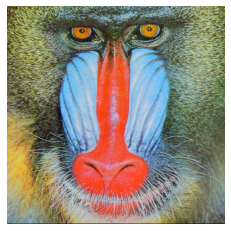

In [25]:
image_rgb = plt.imread("4.2.03.tiff")
plt.imshow(image_rgb)
plt.axis("off")

## Convert to grayscale

(-0.5, 511.5, 511.5, -0.5)

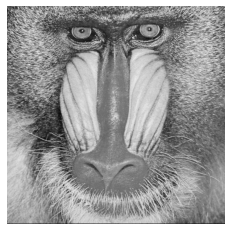

In [28]:
image_bw = 0.2126 * image_rgb[:, :, 0] + 0.7152 * image_rgb[:, :, 1] + 0.0722 * image_rgb[:, :, 2]
plt.imshow(image_bw, cmap='gray')
plt.axis("off")

## Performing randomized SVD

In [30]:
U, Sigma, V = randomized_svd(image_bw, n_components=10)
compressed_image = np.dot(np.dot(U, np.diag(Sigma)), V)

## Plotting SVD results for different number of components

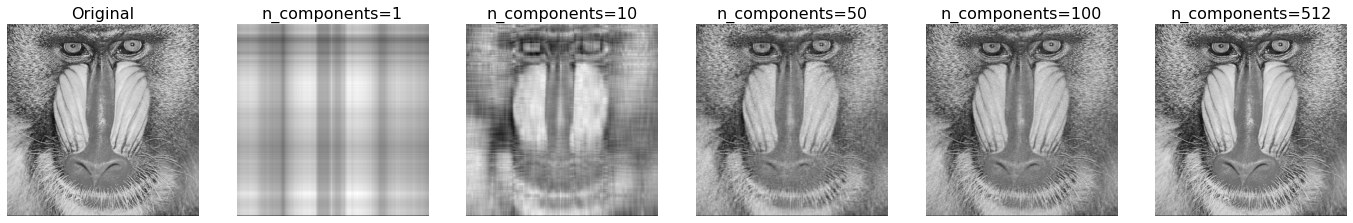

In [29]:
fontsize = 16

f, axes = plt.subplots(1, 6, figsize=(24, 4))

# Plotting the original image
axes[0].imshow(image_bw, cmap='gray')
axes[0].axis("off")
axes[0].set_title("Original", fontsize=fontsize)

for i, n_components in enumerate([1, 10, 50, 100, 512]):
    # Reconstructing the image with different number of comps
    U, Sigma, V = randomized_svd(image_bw, n_components=n_components)
    compressed_image = np.dot(np.dot(U, np.diag(Sigma)), V)
    
    # Plotting the result
    axes[i+1].imshow(compressed_image, cmap="gray")
    axes[i+1].axis("off")
    axes[i+1].set_title(f"n_components={n_components}", fontsize=fontsize)

## Background/Foreground detection

Video download link: http://backgroundmodelschallenge.eu/data/real/Video_003.zip

Instructions: Download the file and extract the `Video_003.avi` and place it in the project directory

In [31]:
vidcap = cv2.VideoCapture('Video_003.avi')

# Read the first frame
success,image = vidcap.read()
count = 0
frames = []

# Keep reading until you run out of frames
while success:
    # Gray scale frame
    image_bw = 0.2126 * image[:, :, 0] + 0.7152 * image[:, :, 1] + 0.0722 * image[:, :, 2]
    frames.append(image_bw)
    success,image = vidcap.read()
  
    count += 1

# Stack all frames to get the video matrix
frames = np.stack(frames, axis=0)
print(f"Shape of the original matrix: {frames.shape}")
# Transpose so that a single frame is in a single column
frames_t = frames.reshape(794, -1).T
print(f"Shape of the transpose matrix: {frames_t.shape}")

Shape of the original matrix: (794, 240, 320)
Shape of the transpose matrix: (76800, 794)


In [53]:
print(frames_t.min())
print(frames_t.max())

0.0
254.99999999999997


## Plotting the video

(-0.5, 76799.5, 793.5, -0.5)

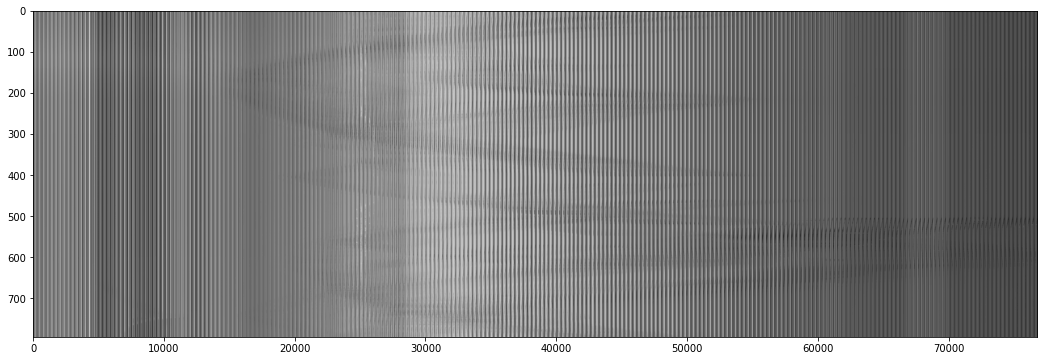

In [20]:
f, ax = plt.subplots(1, 1, figsize=(18, 6))
ax.imshow(frames_t.T, cmap="gray")
plt.axis('tight')

## Robust PCA implementation

Originally from: https://freshprinceofstandarderror.com/ai/robust-principal-component-analysis/

In [33]:
def shrink(X,tau):
    Y = np.abs(X)-tau
    return np.sign(X) * np.maximum(Y,np.zeros_like(Y))

def SVT(X,tau):
    U,S,VT = np.linalg.svd(X,full_matrices=0)
    out = U @ np.diag(shrink(S,tau)) @ VT
    return out

def RPCA(X, n_iter=25):
    n1,n2 = X.shape
    mu = n1*n2/(4*np.sum(np.abs(X.reshape(-1))))
    lambd = 1/np.sqrt(np.maximum(n1,n2))
    thresh = 1e-9 
    
    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    L = np.zeros_like(X)
    count = 0
    while (np.linalg.norm(X-L-S) > thresh) and (count < n_iter):
        L = SVT(X-S+(1/mu)*Y,1/mu)
        S = shrink(X-L+(1/mu)*Y,lambd/mu)
        Y = Y + mu*(X-L-S)
        count += 1
        print(f"{count}/{n_iter} steps completed", end="\r")
        
    return L,S

L, S = RPCA(frames_t)

In [34]:
print(f"L.shape: {L.shape}")
print(f"S.shape: {S.shape}")

L.shape: (76800, 794)
S.shape: (76800, 794)


## Plotting background and foreground separately

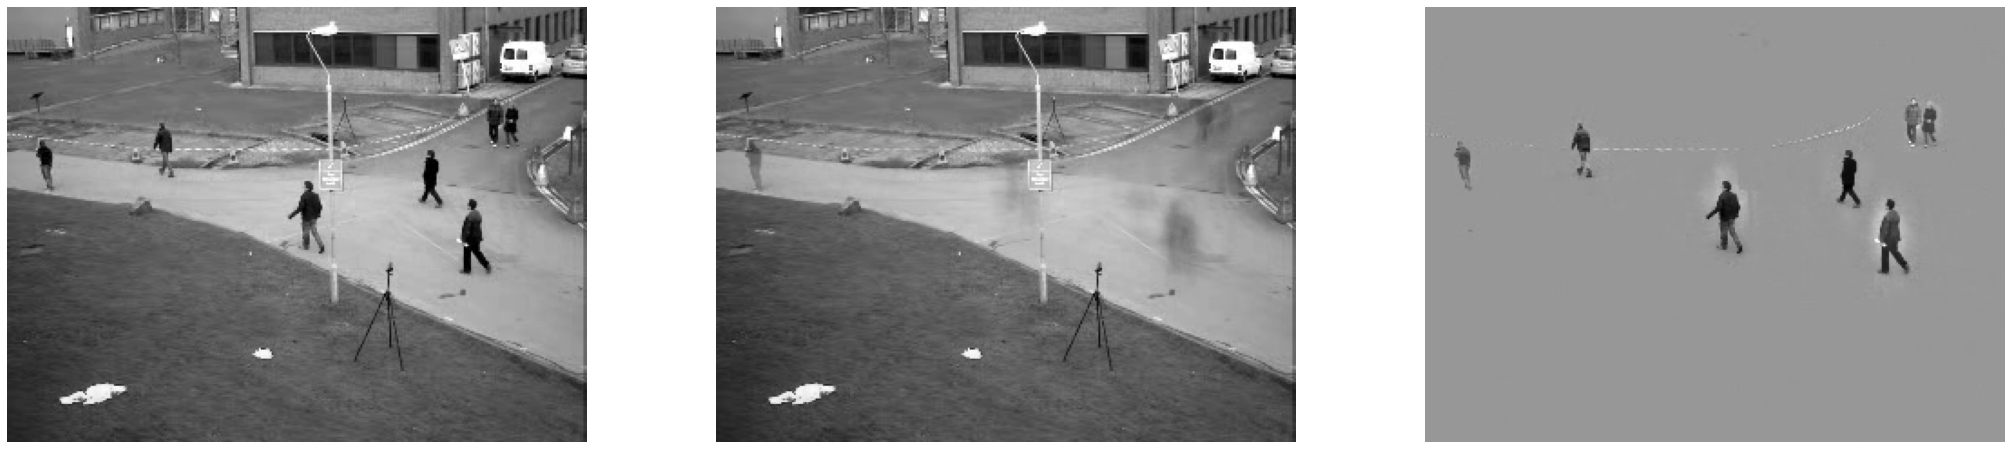

In [32]:
f, axes = plt.subplots(1, 3, figsize=(36, 8))

axes[0].imshow(frames_t[:, 250].reshape(240, 320), cmap="gray")
axes[1].imshow(L[:, 250].reshape(240, 320), cmap="gray")
axes[2].imshow(S[:, 250].reshape(240, 320), cmap="gray")

for ax in axes:
    ax.axis("off")

## Saving all frames of the video

You can then use something like https://ezgif.com/ to get the GIF of the image sequence

In [63]:
import os

os.makedirs("fg_images", exist_ok=True)

for i, frame in enumerate(S.T):
    
    frame_res = frame.reshape(240, 320)
    frame_res = ((frame_res-min_s)*255.0/(max_s-min_s))
    cv2.imwrite(os.path.join("fg_images", f"frame_{i}.jpg"), frame_res)
    
cv2.destroyAllWindows()

## Cool trick! Foreground detection with SVD

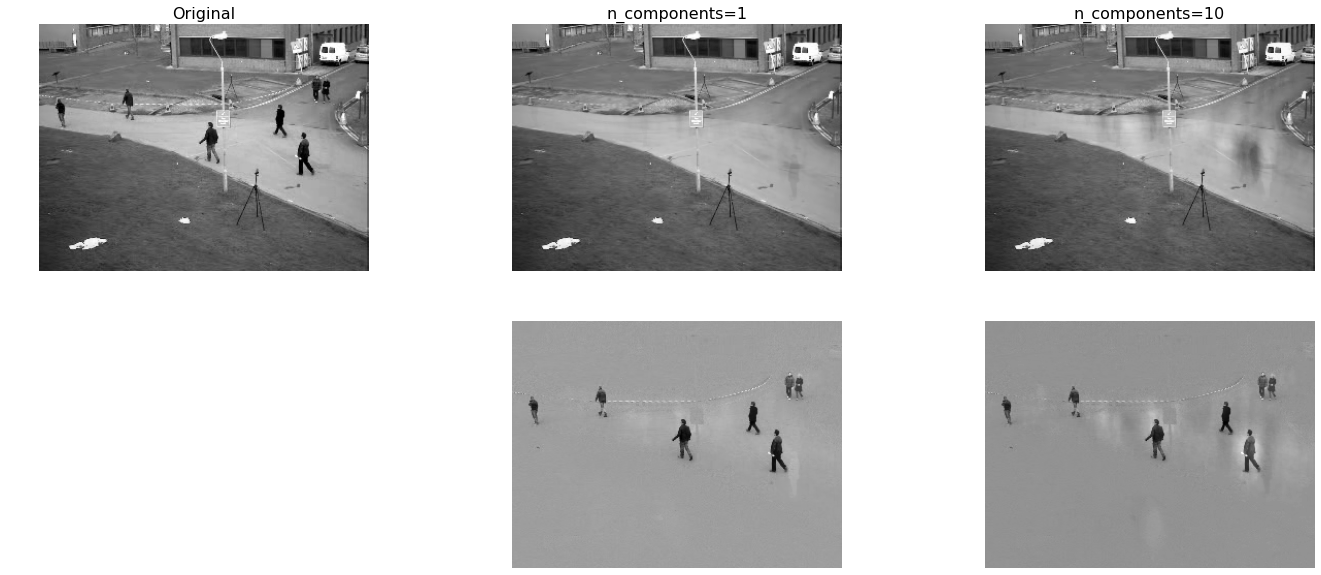

In [10]:
fontsize = 16

f, axes = plt.subplots(2, 3, figsize=(24, 10))

# Plot the original image
axes[0][0].imshow(frames_t[:, 250].reshape(240, 320), cmap='gray')
axes[0][0].axis("off")
axes[0][0].set_title("Original", fontsize=fontsize)
axes[1][0].axis("off")

for i, n_components in enumerate([1, 10]):
    
    # Get the singular components with n_components
    U, Sigma, V = randomized_svd(frames_t, n_components=n_components)
    # Get the low rank video
    low_rank_video = np.dot(np.dot(U, np.diag(Sigma)), V)
    sparse_video = frames_t - low_rank_video
    axes[0][i+1].imshow(low_rank_video[:, 250].reshape(240, 320), cmap="gray")
    axes[0][i+1].axis("off")
    axes[0][i+1].set_title(f"n_components={n_components}", fontsize=fontsize)
    axes[1][i+1].imshow(sparse_video[:, 250].reshape(240, 320), cmap="gray")
    axes[1][i+1].axis("off")